In [ ]:
%%bash
git clone https://github.com/jthickstun/gm-hw2
wget https://courses.cs.washington.edu/courses/cse599i/20au/resources/data.tar.gz
tar -xf data.tar.gz

In [1]:
import sys,os,signal
import numpy as np
import matplotlib.pyplot as plt
import torch

from time import time
from torchvision import transforms
from IPython import display

sys.path.append('gm-hw2')
import bmnist,losses,models

root = 'data/'

In [2]:
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'   # see issue #152
os.environ['CUDA_VISIBLE_DEVICES']='0'

def worker_init(args):
    signal.signal(signal.SIGINT, signal.SIG_IGN)
    
batch_size = 100
kwargs = {'num_workers': 2, 'pin_memory': True, 'worker_init_fn': worker_init}

In [3]:
train_set = bmnist.BinarizedMNIST(root=root, train=True)
test_set = bmnist.BinarizedMNIST(root=root, train=False)

train_loader = torch.utils.data.DataLoader(dataset=train_set,batch_size=batch_size,shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(dataset=test_set,batch_size=batch_size,shuffle=False, **kwargs)

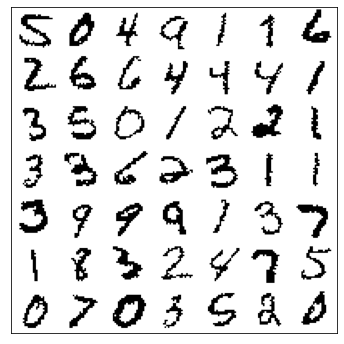

In [18]:
def print_images(x, ax, n=7, d=28, color='black'):
    ax.cla()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    panel = np.zeros([n*d,n*d])
    for i in range(n):
        for j in range(n):
            panel[i*d:(i+1)*d,j*d:(j+1)*d] = x[i*n+j,0]
            
    ax.imshow(panel, cmap=plt.get_cmap('Greys'))
    plt.setp(ax.spines.values(), color=color)

fig, ax = plt.subplots(figsize=(6,6))
            
for i, x in enumerate(train_loader):
    print_images(x, ax)
    break

In [19]:
g = models.PixelCNN().cuda()
loss_func = losses.cross_entropy

loss_train = []
loss_test = []

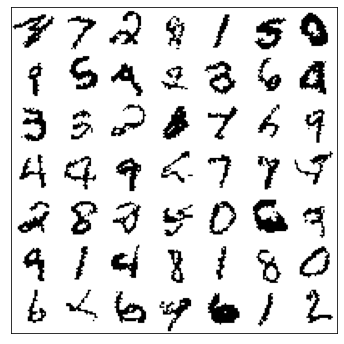

39 23400 19.45361638069153 81.70854 81.6189697265625


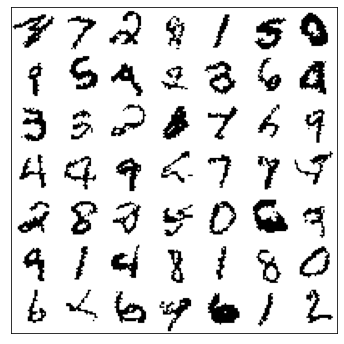

In [20]:
fig, ax = plt.subplots(1, figsize=(6,6))

optimizer = torch.optim.Adam(list(g.parameters()), lr=1e-3)
i = 0
t0 = time()
for epoch in range(40):
    if epoch == 30: optimizer.param_groups[0]['lr'] = lr = 3e-4
    for x in train_loader:
        x = x.cuda()
        loss = loss_func(g(x),x)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        #
        # book-keeping after this
        #
        
        loss_train.append(loss.detach().cpu().numpy())
        
        if i % (1*len(train_loader)) == 0:
            g.eval()
            fake = g.sample(n=49).cuda()
            display.clear_output(wait=True)
            print_images(fake.detach().cpu(), ax, color='black')
            display.display(plt.gcf())
            
            losst = 0
            for x in test_loader:
                x = x.cuda()                
                losst += loss_func(g(x),x).detach()
            
            losst = losst.cpu().numpy() / len(test_loader)
            print(epoch,i,time()-t0,loss.detach().cpu().numpy(),losst)
            t0 = time()
            g.train()
        loss_test.append(losst)
        i += 1

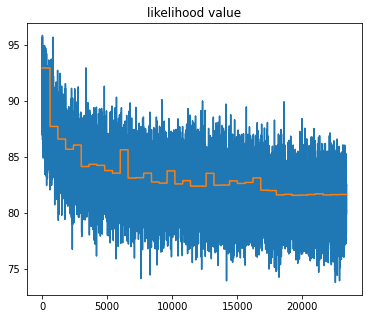

In [21]:
start = 600
end = -1

fig, axes = plt.subplots()
fig.set_figwidth(6)
fig.set_figheight(5)

axes.set_title('likelihood value')
axes.plot(loss_train[start:end])
axes.plot(loss_test[start:end])

In [ ]:
80.5